#implementing simple GNN
##### first I want to implement simple GCN to have good idea about the involvement of GNNs.

I designed a simple, easy-to-understand and small dataset like zachary's karate club. We have 8 individuals in class, friendship cause an edge in our graph.
As you know, each graph is made up by NODES and EDGES.
For example:
![Graph](graphn.png "graphs")

We have 8 nodes and 18 edges.
A matrix called Adjacency MATRIX reveals information about connection of each node to other nodes.
In this example,this matrix is like:

![adjancy](adjancy.png "adjancy")

Adjacency is a $N \times N$ matrix. N is number of nodes.
We have DEGREE MATRIX too, which shows number of neighbours of each node. for example node 5 has 4 neighbours so its degree is 4.

## what we're doing in GNN?
Imagine that our problem is predicting which nodes will become friends?

I'm diving into the discussion, if you want to read more and detailed follow this paper:

SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS by Thomas N. Kipf and Max Welling


$$f(H^{(l)}, A) = \sigma\left( \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}\right)$$

which in this equation we have
$\hat{A} = A + I$ : $I$ is identity matrix

$\hat{D}$  is the diagonal node degree matrix of $\hat{A}$

${W}$ is layer-specific trainable weight matrix

$H^{(l)}$ is the matrix of activations in the ${l}$-th layer: simply the values of i-th layer

$\sigma$ is activation function, i.e. ReLU.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib notebook



import networkx as nx

import imageio
from celluloid import Camera
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

In [2]:
class GCNConv(nn.Module):
    def __init__(self, A, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.A_hat = A+torch.eye(A.size(0))
        self.D     = torch.diag(torch.sum(A,1))
        self.D     = self.D.inverse().sqrt()
        #self.D     = self.D.pow(-0.5)
        self.A_hat = torch.mm(torch.mm(self.D, self.A_hat), self.D)
        self.W     = nn.Parameter(torch.rand(in_channels,out_channels, requires_grad=True))
    
    def forward(self, X):
        out = torch.relu(torch.mm(torch.mm(self.A_hat, X), self.W))
        return out
class Net(torch.nn.Module):
    def __init__(self,A, nfeat, nhid, nout):
        super(Net, self).__init__()
        self.conv1 = GCNConv(A,nfeat, nhid)
        self.conv2 = GCNConv(A,nhid, nout)
        
    def forward(self,X):
        H  = self.conv1(X)
        H2 = self.conv2(H)
        return H2

In [3]:
data=torch.Tensor([[0,1,1,0,1,0,0,1],
                   [1,0,1,0,0,1,1,0],
                   [1,1,0,1,1,0,1,0],
                   [0,0,1,0,1,0,1,1],
                   [1,0,1,1,0,1,1,0],
                   [0,1,0,0,1,0,0,1],
                   [0,1,1,1,1,0,0,0],
                   [1,0,0,1,0,1,0,0]
                   ])
                  
    
target=torch.tensor([0,-1,-1,-1,-1, -1, -1, 1])


Name: 
Type: Graph
Number of nodes: 8
Number of edges: 16
Average degree:   4.0000


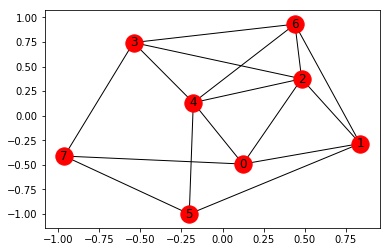

In [4]:
graph = nx.Graph()


for i in range (data.shape[0]):
    graph.add_node(i)

for i in range (data.shape[0]):
    for j in range(data.shape[0]):
        if data[i][j]==1:
            graph.add_edge(i,j)  
            
nx.draw_networkx(graph)
print(nx.info(graph))

# problem?
if node 0 and 7, split up which nodes advocate which person!

In features MATRIX, you can value each friendship too. for example if (1,5) have sincere friendship, value it 10, etc.

In [8]:

#features=torch.Tensor([[10., 0., 0., 0., 0., 0., 0., 0.],
#                       [0., 1., 0., 0., 0., 0., 0., 0.],
#                       [0., 0., 1., 0., 0., 0., 0., 0.],
#                       [0., 0., 0., 1., 0., 0., 0., 0.],
#                       [0., 0., 0., 0., 1., 0., 0., 0.],
#                       [0., 0., 0., 0., 0., 1., 0., 0.],
#                       [0., 0., 0., 0., 0., 0., 1., 0.],
#                       [0., 0., 0., 0., 0., 0., 0., 10.]
#                       ])


features=torch.Tensor([[10, 230, 147,0,0,0,0,0],
                       [5, 52, 200,0,0,0,0,0],
                       [3, 76, 260,0,0,0,0,0],
                       [21, 42, 100,0,0,0,0,0],
                       [0, 12, 16,0,0,0,0,0],
                       [1, 330, 280,0,0,0,0,0],
                       [33, 178, 15,0,0,0,0,0],
                       [11, 90, 96,0,0,0,0,0]
                       ])


T=Net(data,features.size(0), 10, 2)

#features=torch.eye(data.size(0))


In [6]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(T.parameters(), lr=0.01, momentum=0.5)
loss=criterion(T(features),target)

MovieWriter ffmpeg unavailable.


RuntimeError: Requested MovieWriter (ffmpeg) not available

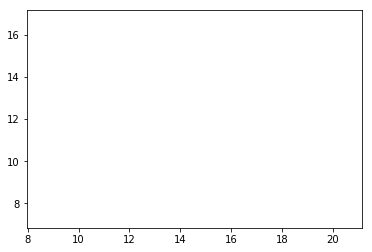

In [7]:
# Plot animation using celluloid
fig = plt.figure()
camera = Camera(fig)

for i in range(200):
    optimizer.zero_grad()
    loss=criterion(T(features), target)
    loss.backward()
    optimizer.step()
    l=(T(features));

    plt.scatter(l.detach().numpy()[:,0],
                l.detach().numpy()[:,1],c=[0, 0, 0, 0 ,1 ,1 ,0, 1])
    for i in range(l.shape[0]):
        text_plot = plt.text(l[i,0], l[i,1], str(i+1))

    camera.snap()

    if i%20==0:
        print("Cross Entropy Loss: =", loss.item())

animation = camera.animate(blit=False, interval=150)
animation.save('./reza.gif',writer='ffmpeg',  fps=60)
HTML(animation.to_html5_video())